In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

from astropy.coordinates import SkyCoord
import astropy.units as u

from nested_pandas import read_parquet

In [2]:
pd.set_option('display.max_columns', 100)
CAT_COLORS = {'2SXPS':'tab:blue', '4XMMDR14':'tab:orange', 'CSC2.1':'tab:green', 'eRASS1':'tab:red', 'XMMSL3':'tab:purple'}
FIELDS = ['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_-25']
# FIELD_COLORS = {'47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25'}
COLORS = {
    "u": "#56b4e9",
    "g": "#009e73",
    "r": "#f0e442",
    "i": "#cc79a7",
    "z": "#d55e00",
    "y": "#0072b2",
}

In [3]:
df_X = pd.read_csv('../../data/final_data_products/xray_in_DP1.csv')

In [4]:
obj = read_parquet('../../data/final_data_products/obj_dp1_xmatch_added.parquet')
dia = read_parquet('../../data/final_data_products/dia_dp1_xmatch_added.parquet')

In [5]:
plt.rcParams.update({
    'font.size': 20,          # Double the default (usually ~10)
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15
})


# Plot positional error by catalog

### broken out into subplots (Figure 1)

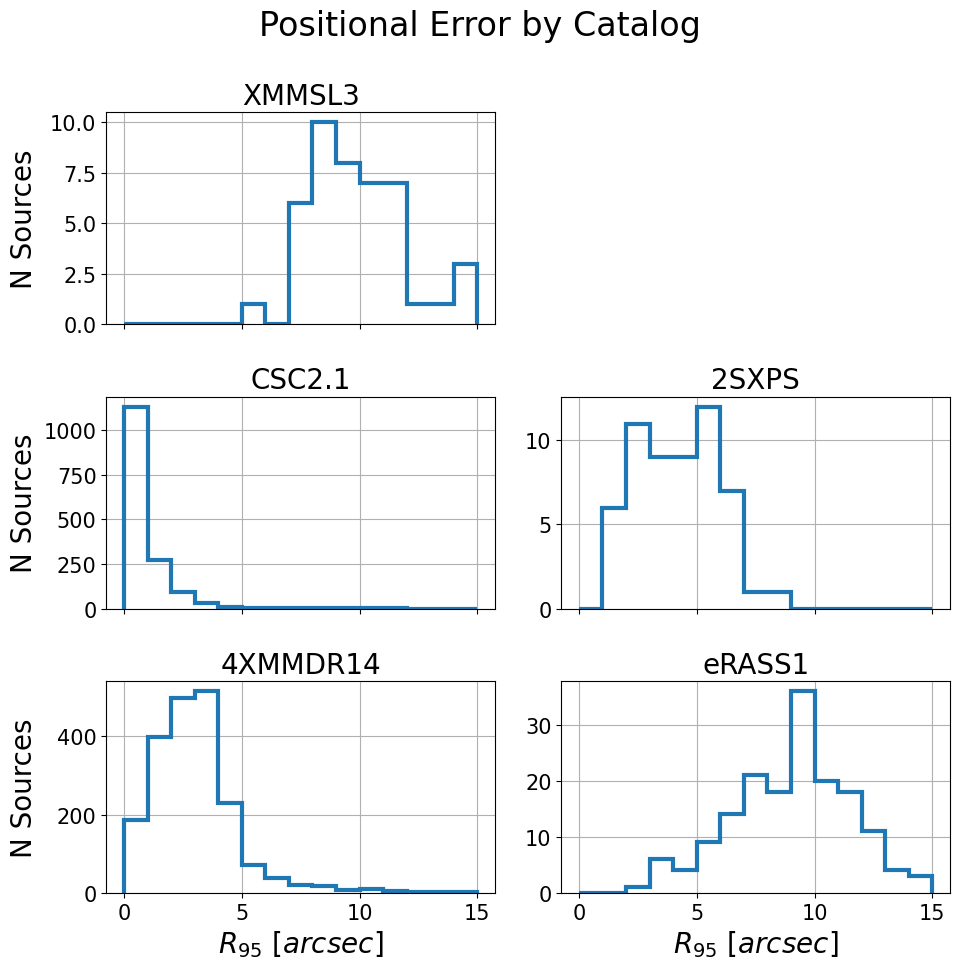

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True)
for i, cat in enumerate(['XMMSL3', '2SXPS', '4XMMDR14', '', 'CSC2.1', 'eRASS1']):
    row = i%3
    col = i%2
    if i == 3:
        axs[0,1].axis('off')
        continue
    sub = df_X.query(f'cat == "{cat}"')['e_pos_95']
    sub.hist(ax=axs[row,col], histtype='step', linewidth=3, bins=np.linspace(0, 15, 16))
    axs[row,col].set_title(cat)
    if row == 2:
        axs[row,col].set_xlabel('$R_{95}$ [$arcsec$]')
    if col == 0:
        axs[row,col].set_ylabel('N Sources')
fig.align_ylabels()
plt.suptitle('Positional Error by Catalog')
plt.tight_layout()
plt.savefig('../../plots/Error_by_catalog_subplots.pdf')

# Plot number of sources per catalog in each field (Figure 2)

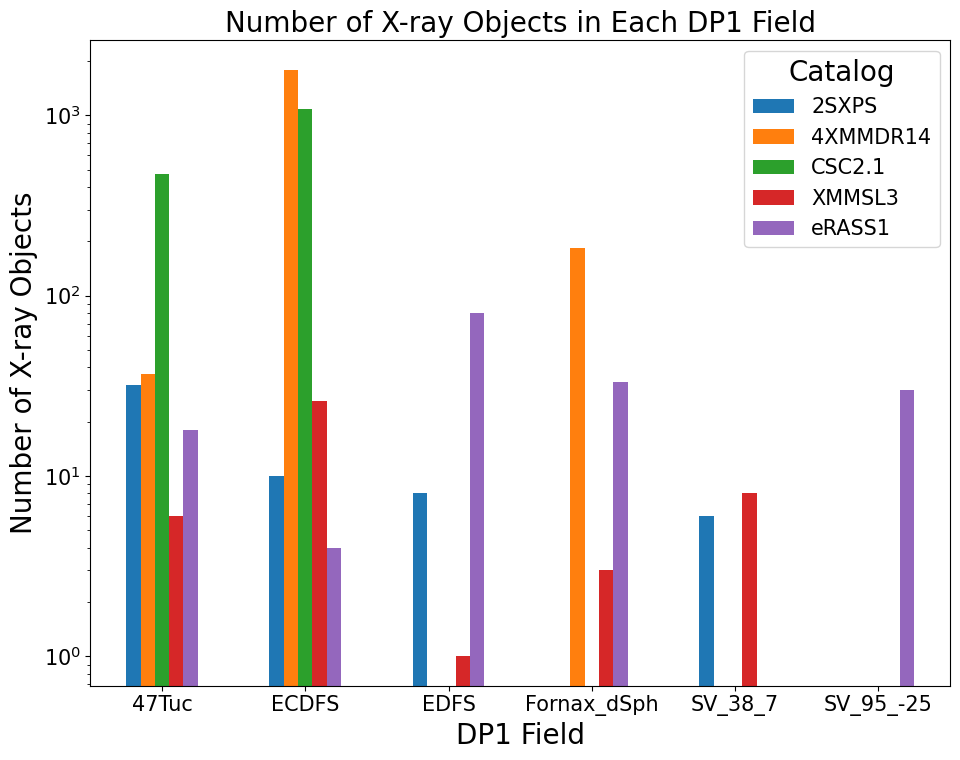

In [7]:
gb = df_X.groupby(['field', 'cat'])['ra'].count()

gb = gb.reset_index()
gb.rename({'field': 'DP1 Field', 'cat': 'Catalog', 'ra': 'Number of Sources'}, axis=1, inplace=True)

pivot = pd.pivot_table(gb, index=['DP1 Field'], columns=['Catalog'])
pivot.replace(np.nan, 0, inplace=True)
pivot = pivot['Number of Sources']
pivot

ax = pivot.plot.bar(figsize=(10,8))
ax.set_ylabel('Number of X-ray Objects')
ax.set_xlabel('DP1 Field')
ax.set_title('Number of X-ray Objects in Each DP1 Field')
plt.xticks(rotation=0)
ax.set_yscale('log')
plt.tight_layout()
# plt.savefig('../plots/xray_per_field_log.png')

plt.savefig('../../plots/xray_per_field.pdf')

# Plot counterparts spatially (Figure 3)

In [8]:
FIELDS = {'ECDFS': (53.13, -28.10), 'EDFS':(59.10, -48.73), 'SV_38_7':(37.86, 6.98), 
          'SV_95_-25':(95.00, -25.00), '47Tuc':(6.02, -72.08), 'Fornax_dSph':(40.00, -34.45)}

In [9]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

# Create dummy WCS: assumes linear scaling in RA/Dec
field_wcs = {}
for field, center in FIELDS.items():
    w = WCS(naxis=2)
    w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
    w.wcs.crval = [center[0], center[1]]      # Center RA/Dec
    w.wcs.crpix = [100, 100]        # Reference pixel
    w.wcs.cdelt = [-0.01, 0.01]     # Degrees per pixel
    field_wcs[field] = w

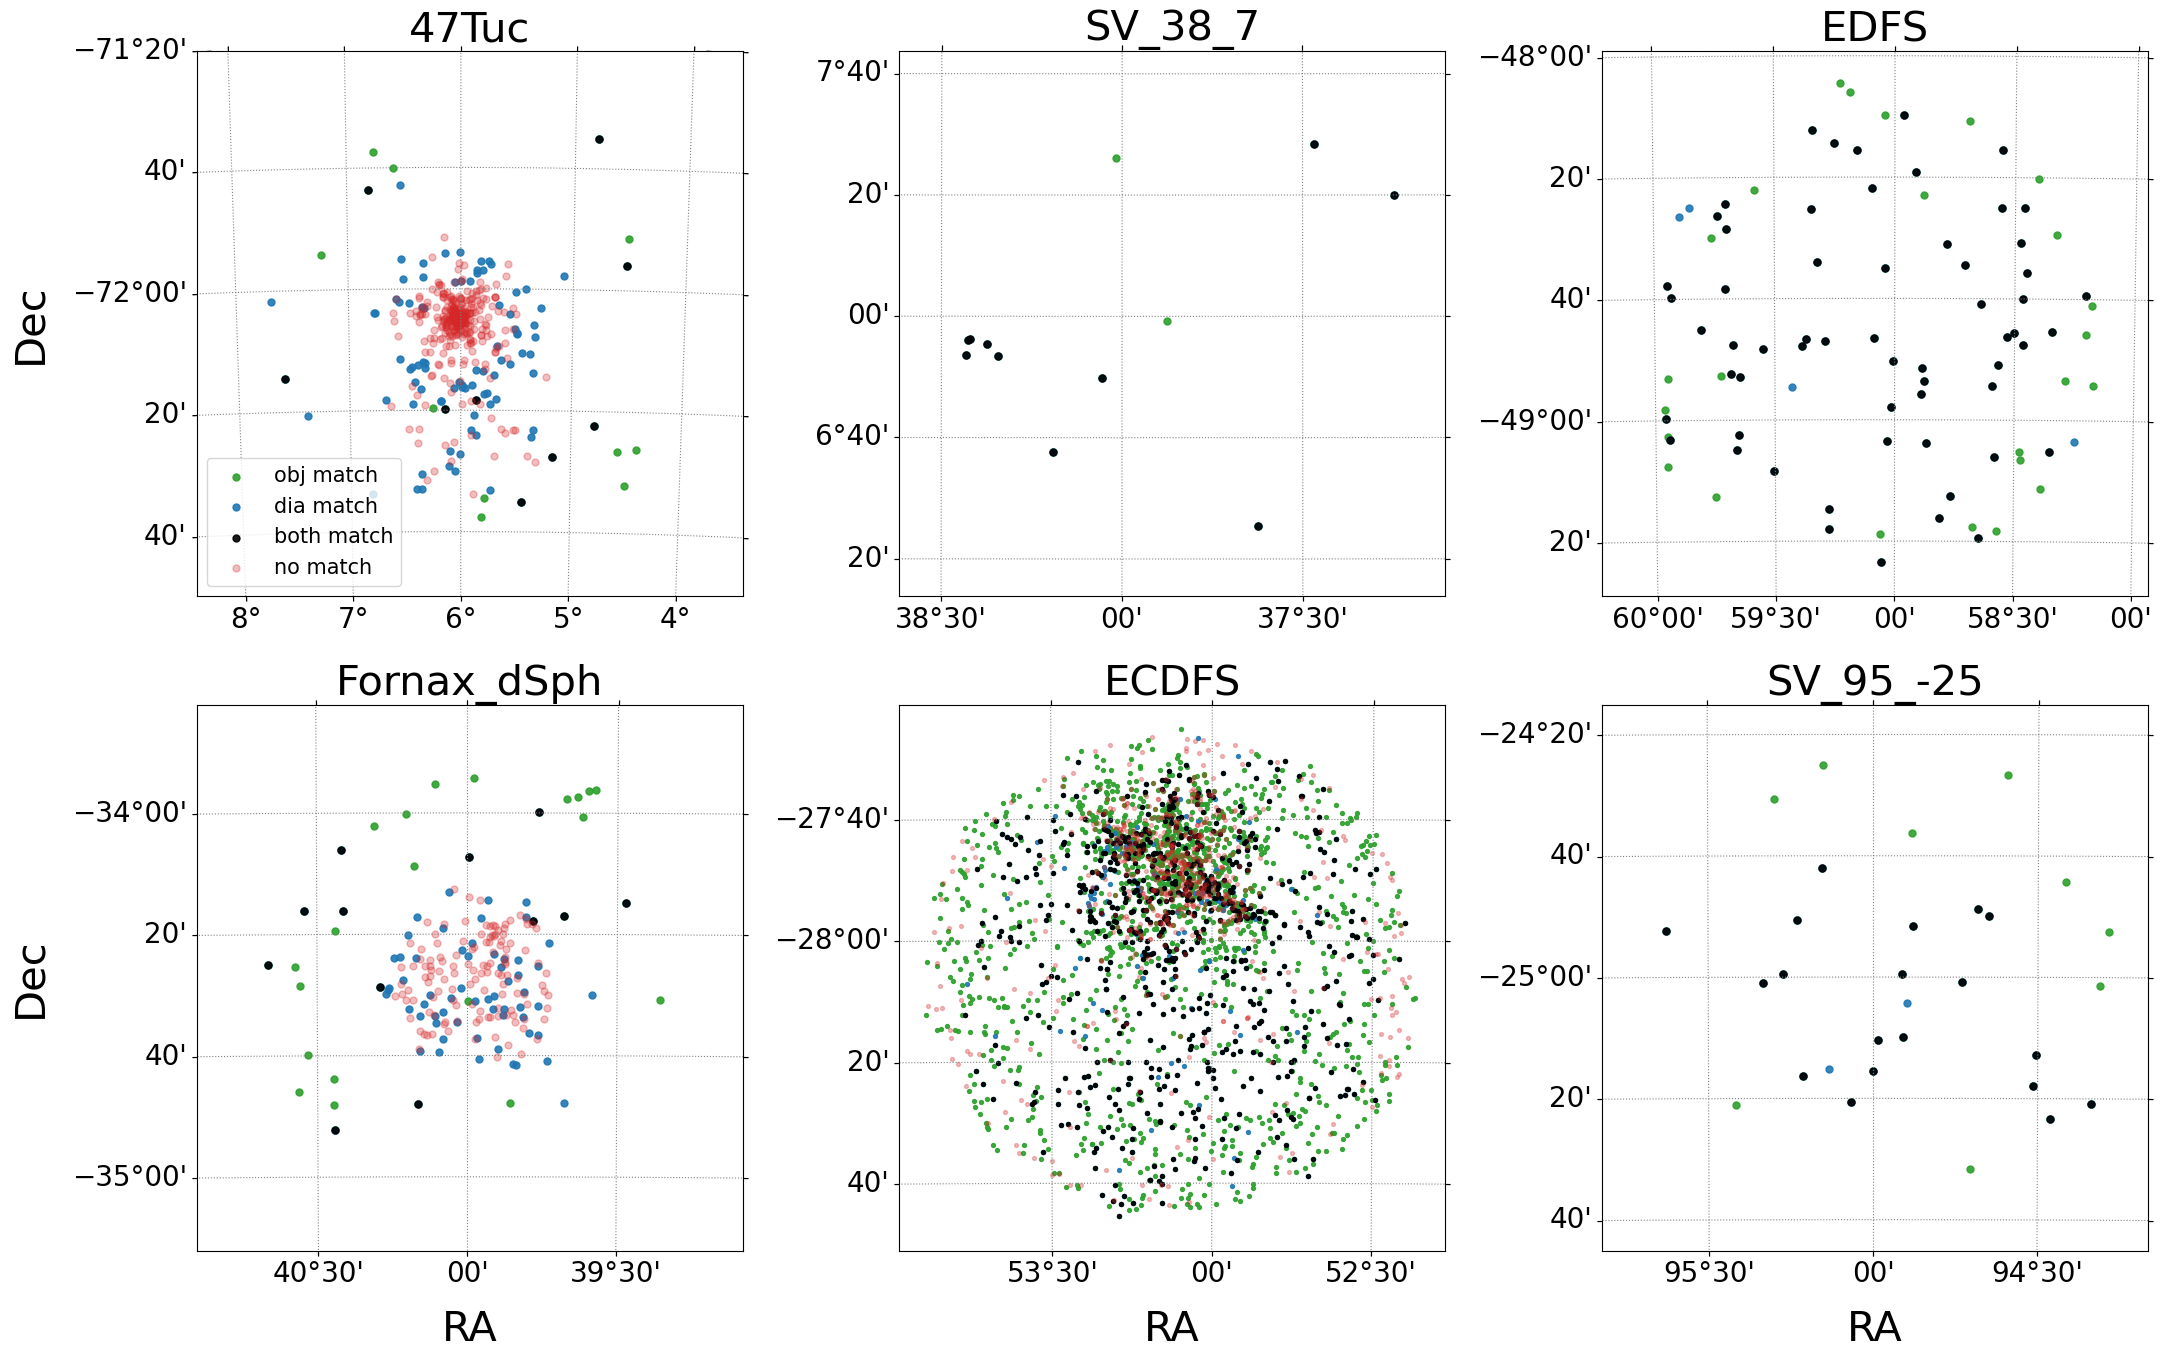

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(22, 14), subplot_kw={'projection': w})
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_-25']):
    row = i%2
    col = i%3
    axs[row, col].reset_wcs(field_wcs[field])

    # observed = ind_df[ind_df['DP1_flag']]
    ind_field = df_X.query(f'field == "{field}"')
    matches_field = obj.query(f'field_X == "{field}"')

    axs[row, col].coords['ra'].set_major_formatter('d')

    objs_in_field = ind_field[ind_field['obj_flag']]
    dias_in_field = ind_field[ind_field['dia_flag']]
    both_in_field = ind_field[(ind_field['dia_flag'] & ind_field['obj_flag'])]
    none_in_field = ind_field[~(ind_field['dia_flag'] | ind_field['obj_flag'])]

    s = 25
    if field == 'ECDFS':
        s = 8

    if not objs_in_field.empty:
        objs_in_field.plot.scatter(x='ra', y='dec', s=s, ax=axs[row, col],alpha=.9, color='tab:green',
                                   label='obj match', transform=axs[row, col].get_transform('world'), rasterized=True)
    if not dias_in_field.empty: 
        dias_in_field.plot.scatter(x='ra', y='dec', s=s, alpha=.9, ax=axs[row, col], color='tab:blue',
                                   transform=axs[row, col].get_transform('world'), label='dia match', rasterized=True)
    if not both_in_field.empty:
        both_in_field.plot.scatter(x='ra', y='dec', s=s, alpha=.9, transform=axs[row, col].get_transform('world'), 
                                   ax=axs[row, col], color='k', label='both match', rasterized=True)
    if not none_in_field.empty:
        none_in_field.plot.scatter(x='ra', y='dec', s=s, ax=axs[row, col],alpha=.3, color='tab:red',
                               transform=axs[row, col].get_transform('world'), label='no match', rasterized=True)

    rad = .75 # show +/- rad arcsc from center of field
    ra, dec = FIELDS[field][0], FIELDS[field][1]
    ra_max, ra_min = ra  + rad / np.cos(np.radians(abs(dec))), ra  - rad / np.cos(np.radians(abs(dec)))    # RA increases to the left
    dec_min, dec_max = dec - rad, dec + rad

    if row < 1:
        axs[row, col].set_xlabel('')
    else:
        axs[row, col].set_xlabel('RA', fontsize=30)

    if col > 0:
        axs[row, col].set_ylabel('')
    else:
        axs[row, col].set_ylabel('Dec', fontsize=30)



    # Bottom-left and top-right as SkyCoord objects
    bl = SkyCoord(ra=ra_max * u.deg, dec=dec_min * u.deg, frame='icrs')
    tr = SkyCoord(ra=ra_min * u.deg, dec=dec_max * u.deg, frame='icrs')
    
    # Convert to pixel coords using WCS
    bl_pix = axs[row,col].wcs.world_to_pixel(bl)
    tr_pix = axs[row,col].wcs.world_to_pixel(tr)
    
    # Now set pixel limits explicitly
    axs[row,col].set_xlim(bl_pix[0], tr_pix[0])
    axs[row,col].set_ylim(bl_pix[1], tr_pix[1])

    if (row + col) >= 1:
        # axs[row, col].minor_ticks_on()
        axs[row, col].coords['ra'].set_ticks(spacing=0.5 * u.deg)
        axs[row, col].coords['ra'].set_format_unit(u.deg)                    # Force label to be in degrees
        axs[row, col].coords['ra'].set_major_formatter('dd:mm') 
    axs[row, col].set_aspect('equal')
    axs[row, col].grid(True, color='gray', ls='dotted')

    axs[row, col].coords['ra'].set_ticklabel(size=20)
    axs[row, col].coords['dec'].set_ticklabel(size=20)

    axs[row,col].set_title(field, fontsize=30)
    
    if i != 0:
        axs[row,col].get_legend().remove()

plt.tight_layout()
plt.savefig('../../plots/matches_spatial.pdf')

## Plot number of candidate matches per X-ray source

## Plot stetsonJs

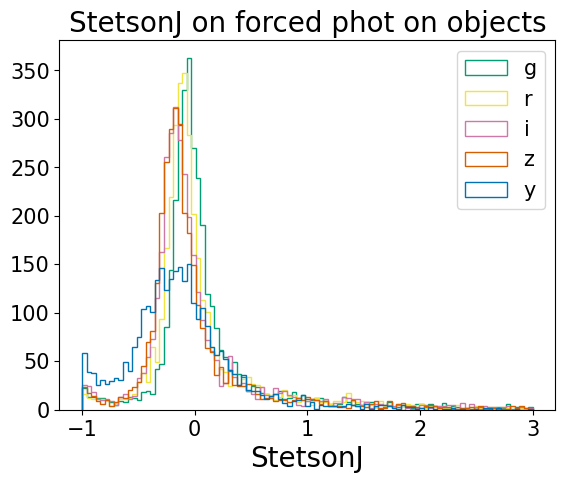

Text(0.5, 0, 'StetsonJ')

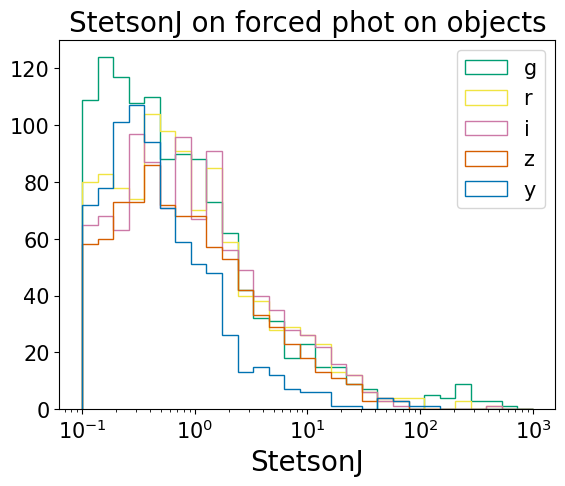

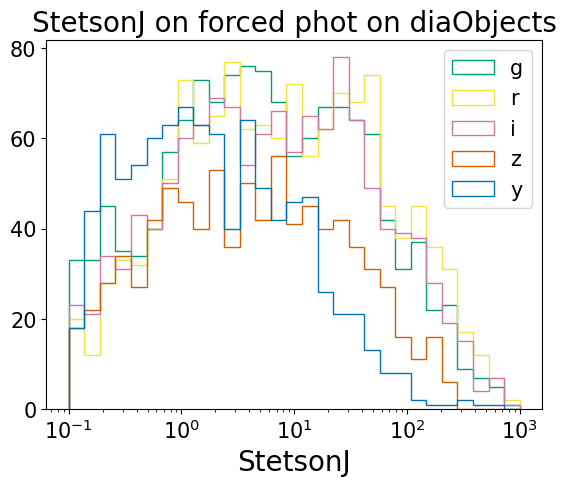

In [11]:
plt.figure()
for band in 'grizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.hist(obj[col], bins=np.linspace(-1, 3, 100), histtype='step', color=COLORS[band], label=band)
    # plt.xscale('log')
plt.legend()
plt.xlabel('StetsonJ')
plt.title('StetsonJ on forced phot on objects')
plt.show()

for band in 'grizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.hist(obj[col], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.xlabel('StetsonJ')
plt.title('StetsonJ on forced phot on objects')

plt.figure()
for band in 'grizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.hist(dia[col], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.title('StetsonJ on forced phot on diaObjects')
plt.xlabel('StetsonJ')

Text(0.5, 0, 'StetsonJ')

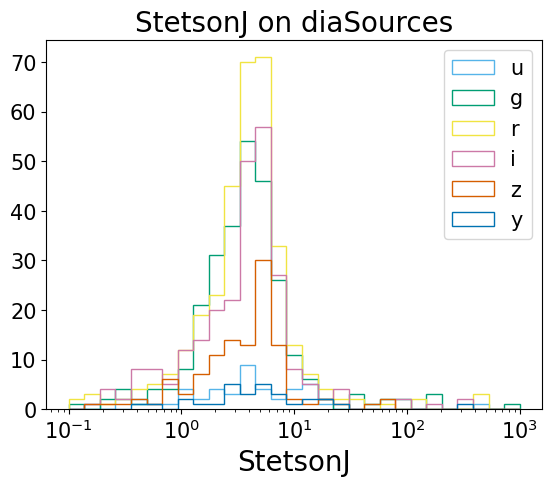

In [12]:
plt.figure()
for band in 'ugrizy':
    plt.hist(dia[f'{band}_psfFluxStetsonJ'], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.title('StetsonJ on diaSources')
plt.xlabel('StetsonJ')

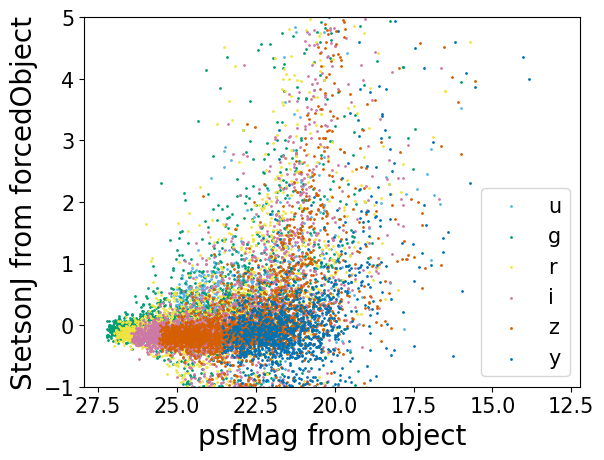

In [13]:
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    sub = obj[(obj[f"{band}_psfFlux"] / obj[f"{band}_psfFluxErr"]) > 5]
    plt.scatter(sub[f"{band}_psfMag"], sub[col], color=COLORS[band], label=band, s=1)
    # plt.yscale('log')
plt.ylim([-1, 5])
plt.gca().invert_xaxis()
plt.xlabel('psfMag from object')
plt.ylabel('StetsonJ from forcedObject')
plt.legend()

# Number densities of sources

In [14]:
dens = pd.read_csv('../../data/intermediate_data_products/xray_in_DP1_densities.csv')


<Axes: >

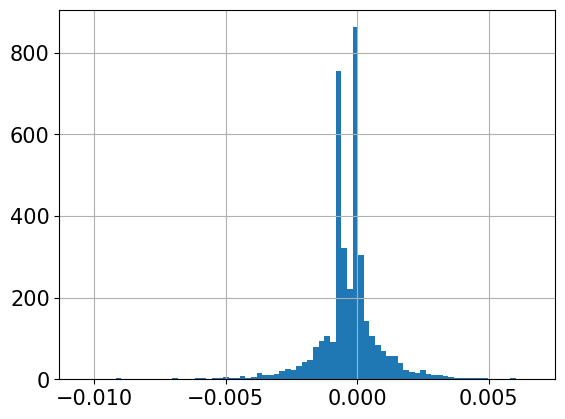

In [15]:
resids = dens['N_asec2'] - (dens['n_obj_outer'] / dens['area_outer_asec2'])
resids.hist(bins=80)

### densities per field

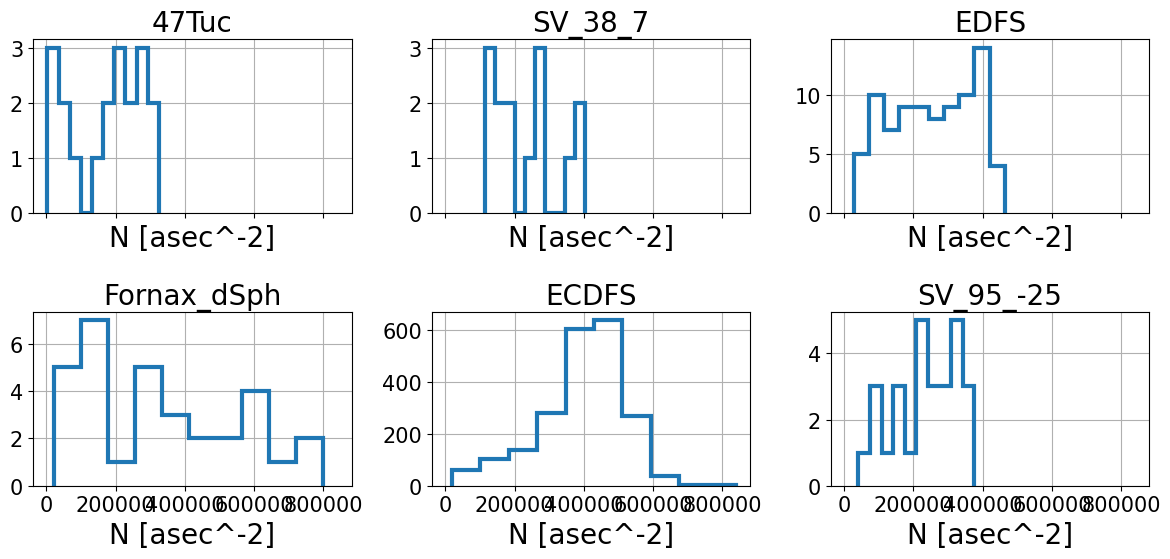

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(12,6))
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_-25']):
    row = i%2
    col = i%3
    sub = dens[dens['obj_flag']].query(f'field == "{field}"')['N_deg2']
    sub.hist(ax=axs[row,col], histtype='step', linewidth=3)
    axs[row,col].set_title(field)
    axs[row,col].set_xlabel('N [asec^-2]')
plt.tight_layout()

# Plot reliability of each counterpart

### obj matches

In [17]:
obj_closest = read_parquet('../../data/final_data_products/obj_dp1_xmatch_closest.parquet')

### Plot reliability of closest counterpart

Text(0.5, 0, 'Reliability of closest counterpart')

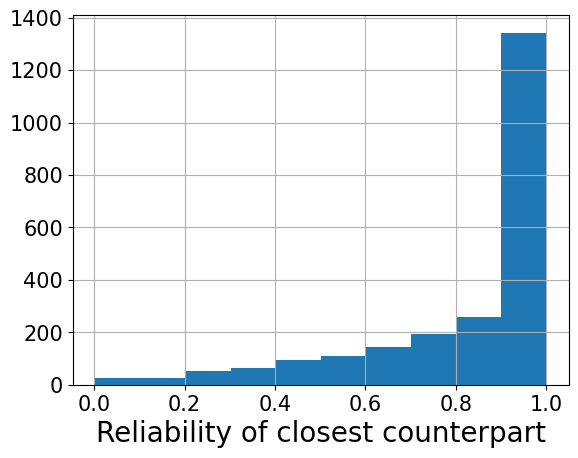

In [18]:
fig, ax = plt.subplots()
obj_closest['reliability'].hist(ax=ax)
plt.xlabel('Reliability of closest counterpart')

In [19]:
print(f'N > 90% reliable: {sum(obj_closest['reliability']>.9)}')
print(f'pct > 90% reliable: {sum(obj_closest['reliability']>.9)/len(obj_closest['reliability']>.9)*100:.2f}')

N > 90% reliable: 1344
pct > 90% reliable: 58.08


# Plot histogram of reliabilities by field (Figure 4)

In [20]:
FIELDS

{'ECDFS': (53.13, -28.1),
 'EDFS': (59.1, -48.73),
 'SV_38_7': (37.86, 6.98),
 'SV_95_-25': (95.0, -25.0),
 '47Tuc': (6.02, -72.08),
 'Fornax_dSph': (40.0, -34.45)}

47Tuc
N > 90% reliable: 8
pct > 90% reliable: 42.11
ECDFS
N > 90% reliable: 1295
pct > 90% reliable: 60.63
EDFS
N > 90% reliable: 21
pct > 90% reliable: 24.71
Fornax_dSph
N > 90% reliable: 10
pct > 90% reliable: 31.25
SV_38_7
N > 90% reliable: 3
pct > 90% reliable: 21.43
SV_95_-25
N > 90% reliable: 7
pct > 90% reliable: 25.00


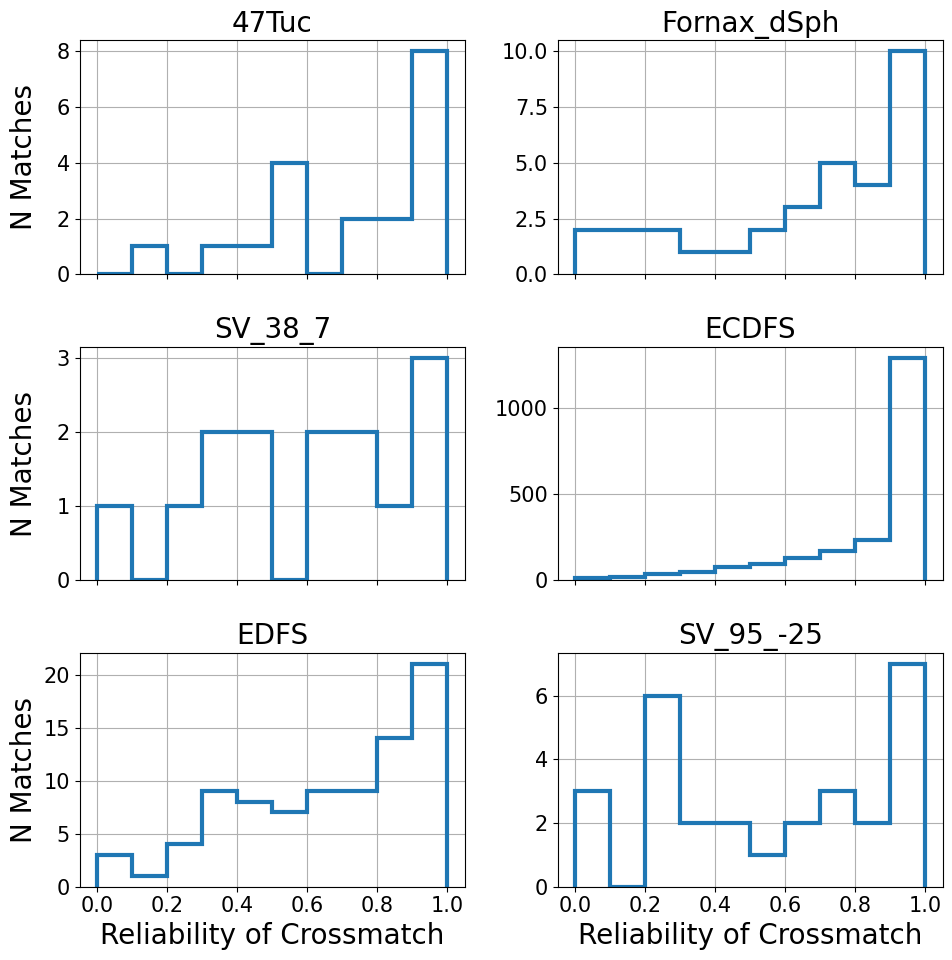

In [21]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(10,10))
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_-25']):
    row = i%3
    col = i%2
    sub = obj_closest.query(f'field_X == "{field}"')['reliability']
    sub.hist(ax=axs[row,col], histtype='step', linewidth=3, bins=np.linspace(0, 1, 11))
    print(f'{field}')
    print(f'N > 90% reliable: {sum(sub>.9)}')
    print(f'pct > 90% reliable: {sum(sub>.9)/len(sub>.9)*100:.2f}')
    axs[row,col].set_title(field)
    if row == 2:
        axs[row,col].set_xlabel('Reliability of Crossmatch')

    if col == 0:
        axs[row,col].set_ylabel('N Matches')
plt.tight_layout()
fig.align_ylabels()
plt.savefig('../../plots/reliability_by_field.pdf')

# Figure 5: Breakdown of X-ray sources with matches by F_X, X-ray localization, and stellar density

In [22]:
reliable = read_parquet('../../data/final_data_products/obj_dp1_xmatch_added_reliable.parquet')

In [23]:
def add_obj_cols_on_id(df, obj, cols, left_on='objectId'):
    cols = cols + ['objectId']
    return df.merge(obj[cols], how='left', left_on=left_on, right_on='objectId')



max_rel = obj.sort_values('reliability').drop_duplicates(subset=['name_X'], keep='last')['reliability', 'name_X']
dens['reliable_flag'] = [name in reliable['name_X'].values for name in df_X['name'].values]
dens['max_reliability'] = [max_rel.query(f'name_X == "{name}"')['reliability'].iloc[0] if name in max_rel['name_X'].values else np.nan for name in dens['name'].values]

def make_reliability_plot(ax):
    hb = plt.hexbin(dens['N_deg2'], dens['e_pos_95'], C=dens['max_reliability'], reduce_C_function=np.median, gridsize=13)
    fig.colorbar(hb, ax=ax, label='Median Reliability')
    ax.set_xlabel('Stellar Density [N deg$^{-2}$]')
    ax.set_ylabel('X-ray Positional Error (95%)')
    plt.title('Factors Impacting Reliability')

In [24]:
df_X['reliable_flag'] = [name in reliable['name_X'].values for name in df_X['name'].values]

def plot_breakdown_F_X(ax, df, bins, match='obj', col='F', color='b', show_counts=False, show_SE=True, label='', linewidth=1.5):
    p_match = {'obj': [], 'dia': [], 'rel':[]}
    n_match = {'obj': [], 'dia': [], 'rel':[]}
    n_total = []
    for i in range(len(bins)-1):
        ll = bins[i]
        ul = bins[i+1]
        sub = df.query(f'{ll} < {col} < {ul}') 
        if len(sub) > 0: 
            obj_match = sum(sub['obj_flag'])
            dia_match = sum(sub['dia_flag'])
            rel_match = sum(sub['reliable_flag'])
            n = len(sub)
            p_match['obj'].append(obj_match / n)
            p_match['dia'].append(dia_match / n)
            p_match['rel'].append(rel_match / n)
            n_match['obj'].append(obj_match)
            n_match['dia'].append(dia_match)
            n_match['rel'].append(rel_match) 
            n_total.append(n)
        else: 
            p_match['obj'].append(0)
            p_match['dia'].append(0) 
            p_match['rel'].append(0) 
            n_match['obj'].append(0)
            n_match['dia'].append(0)
            n_match['rel'].append(0) 
            n_total.append(0)

    p_match[match][0] = 0
    ax.step(bins[:-1], p_match[match], label=label, color=color, linewidth=linewidth)
    if show_counts:
        # plot count in F_X bin with counterpart over total count in F_X bin
        for i in range(len(bins) - 1):
            ax.annotate(f"{n_match[match][i]}/{n_total[i]}", (bins[i-1], p_match[match][i]), size=8)
    if show_SE:
        # plot standard error as errorbar
        ax.errorbar((np.sqrt(bins[1:] * bins[:-1]))[:-1], p_match[match][1:], 
                     yerr=np.sqrt(np.array(p_match[match]) * (1-np.array(p_match[match])) / np.array(n_total))[1:], 
                     fmt='.', capsize=2, color=color)
    
    ax.set_xlabel(r'$F_x$ [erg s$^{-1}$ cm$^{-2}$]')
    ax.set_ylabel('Fraction with counterpart')

/tmp/ipykernel_2372/1586812061.py:41: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(np.array(p_match[match]) * (1-np.array(p_match[match])) / np.array(n_total))[1:],
/tmp/ipykernel_2372/1586812061.py:41: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(np.array(p_match[match]) * (1-np.array(p_match[match])) / np.array(n_total))[1:],
/tmp/ipykernel_2372/1586812061.py:41: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(np.array(p_match[match]) * (1-np.array(p_match[match])) / np.array(n_total))[1:],
/tmp/ipykernel_2372/1586812061.py:41: RuntimeWarning: invalid value encountered in divide
  yerr=np.sqrt(np.array(p_match[match]) * (1-np.array(p_match[match])) / np.array(n_total))[1:],


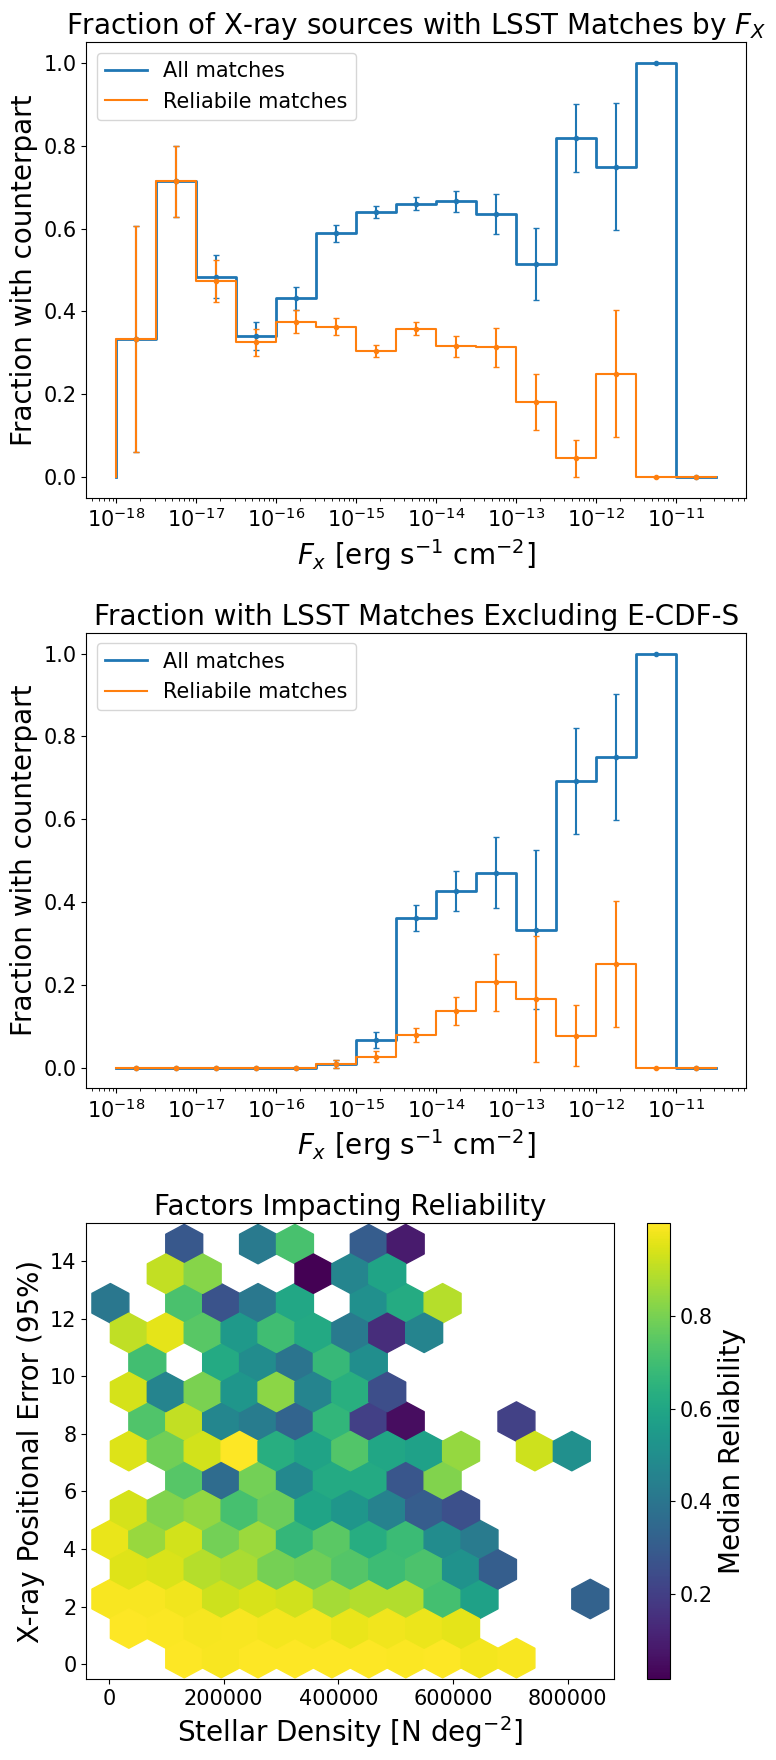

In [25]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,18))

# plot fraction of matches by F_X
plot_breakdown_F_X(axs[0], df_X, np.logspace(-18, -10, 17), color='C0', label='All matches', linewidth=2)
plot_breakdown_F_X(axs[0], df_X, np.logspace(-18, -10, 17), 'rel', color='C1', label='Reliabile matches') 
axs[0].set_title('Fraction of X-ray sources with LSST Matches by $F_X$')
axs[0].legend()
axs[0].set_xscale('log')

plot_breakdown_F_X(axs[1],df_X[df_X['field'] != 'ECDFS'], np.logspace(-18, -10, 17), color='C0', label='All matches', linewidth=2)
plot_breakdown_F_X(axs[1],df_X[df_X['field'] != 'ECDFS'], np.logspace(-18, -10, 17), 'rel', color='C1', label='Reliabile matches') 
axs[1].set_title('Fraction with LSST Matches Excluding E-CDF-S')
axs[1].legend()
axs[1].set_xscale('log')

make_reliability_plot(axs[2])

plt.tight_layout()
plt.savefig('../../plots/reliability_breakdown.pdf')

In [26]:
reliable['field_X'].value_counts()

field_X
ECDFS          1295
EDFS             21
Fornax_dSph      10
47Tuc             8
SV_95_-25         7
SV_38_7           3
Name: count, dtype: int64[pyarrow]

In [27]:
reliable['cat_X'].value_counts()

cat_X
CSC2.1      764
4XMMDR14    534
eRASS1       37
2SXPS         6
XMMSL3        3
Name: count, dtype: int64[pyarrow]

## PCT of sources fainter than Gaia, SDSS, PanSTARRS maglim

In [28]:
max_mags = reliable[[x for x in reliable if x[1:] == '_psfMag']].min(axis=1)
max_mags_all = obj_closest[[x for x in reliable if x[1:] == '_psfMag']].min(axis=1)

##### Gaia

In [29]:
sum(max_mags > 21) / len(max_mags)

0.7209821428571429

In [30]:
sum(max_mags_all > 21) / len(max_mags_all)

0.7830596369922213

##### SDSS

In [31]:
sum(max_mags > 23) / len(max_mags)

0.32142857142857145

In [32]:
sum(max_mags_all > 23) / len(max_mags_all)

0.45073465859982714

##### PanSTARRS

In [33]:
sum(max_mags > 24) / len(max_mags)

0.15327380952380953

In [34]:
sum(max_mags_all > 24) / len(max_mags_all)

0.27095937770095074

## Histogram of source psfMag (Figure 5)

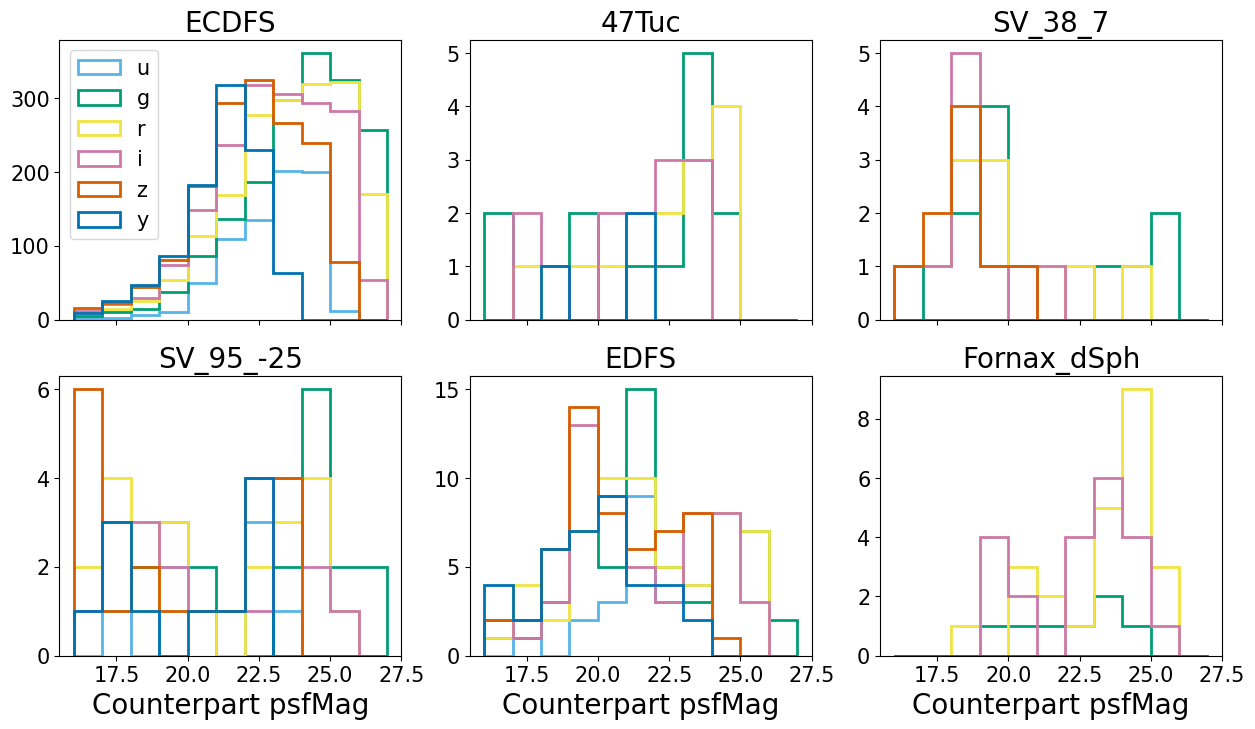

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(15,8))
for i, field in enumerate(FIELDS):
    row = i%2
    col = i%3
    field_objs = obj_closest.query(f'field_X == "{field}"')
    
    axs[row,col].set_title(field)
    for band in 'ugrizy':
        sub = field_objs[(field_objs[f'{band}_psfFlux'] / field_objs[f'{band}_psfFluxErr']) > 5]
        # sub[f'{band}_psfMag'].hist(ax=axs[row,col], alpha=.5, bins = np.arange(16, 28, 1),
        #                            color=COLORS[band], linewidth=0, label=band, grid=False)
        sub[f'{band}_psfMag'].hist(ax=axs[row,col], histtype='step', bins = np.arange(16, 28, 1),
                                   color=COLORS[band], linewidth=2, label=band, grid=False)
    axs[row,col].set_xlim([15.5, 27.5])
    if (row == 1):
        axs[row,col].set_xlabel('Counterpart psfMag')
    if i == 0:
        axs[row,col].legend()

# plt.tight_layout()
# plt.savefig('../../plots/mag_of_matches_SNR5.pdf')

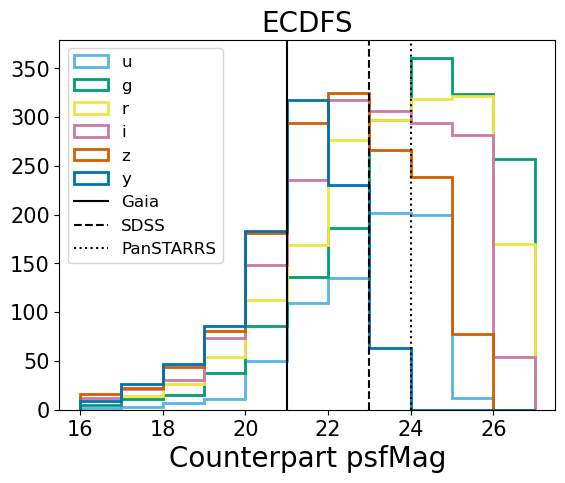

In [36]:
fig, ax = plt.subplots()
field='ECDFS'
field_objs = obj_closest.query(f'field_X == "{field}"')
offset=0
ax.set_title(field)
for i,band in enumerate('ugrizy'):
    sub = field_objs[(field_objs[f'{band}_psfFlux'] / field_objs[f'{band}_psfFluxErr']) > 5]
    # sub[f'{band}_psfMag'].hist(ax=ax, alpha=.5, bins = i*offset+np.arange(16, 28, 1),
    #                            color=COLORS[band], linewidth=0, label=band, grid=False)
    sub[f'{band}_psfMag'].hist(ax=ax, histtype='step', bins = i*offset+np.arange(16, 28, 1),
                               color=COLORS[band], linewidth=2, grid=False, label=band)
ax.set_xlim([15.5, 27.5])
ax.set_xlabel('Counterpart psfMag')
ax.axvline(21, label='Gaia', color='k')
ax.axvline(23, label='SDSS', linestyle='--', color='k')
ax.axvline(24, label='PanSTARRS', linestyle=':',  color='k')
ax.legend(fontsize=12)


# StetsonJ and reliability Figure 6

In [37]:
def other_fig_00(ax):
    for band in 'ugrizy':
        col = f'{band}_psfFluxForcedStetsonJ'
        sub = obj[(obj[f"{band}_psfFlux"] / obj[f"{band}_psfFluxErr"]) > 5]
        ax.scatter(sub[f"{band}_psfMag"], sub[col], color=COLORS[band], label=band, s=1, rasterized=True)
        ax.set_yscale('symlog')

    tick_positions = [-1, 0, 1, 10, 100, 1000]
    tick_labels = ['-1', '0', '1', '10', '100', '1000']
    
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(tick_labels)

    ax.set_ylim([-1.1, 1e3])
    ax.invert_xaxis()
    ax.set_xlabel('psfMag from Object')
    ax.set_ylabel('StetsonJ from forcedObject')
    ax.legend(markerscale=4)



#### old plot

In [38]:
# fig, axs = plt.subplots(1,2,figsize=(12,5), sharey=True)
# other_fig_00(axs[1])

# axs[0].scatter(obj['reliability'], obj['r_psfFluxForcedStetsonJ'], marker='.', rasterized=True)
# axs[0].set_ylabel('r-band Stetson J from Match')
# axs[0].set_xlabel('Reliability of Match')

# plt.tight_layout()
# fig.savefig('../../plots/stetsonJ.pdf')

#### new plot

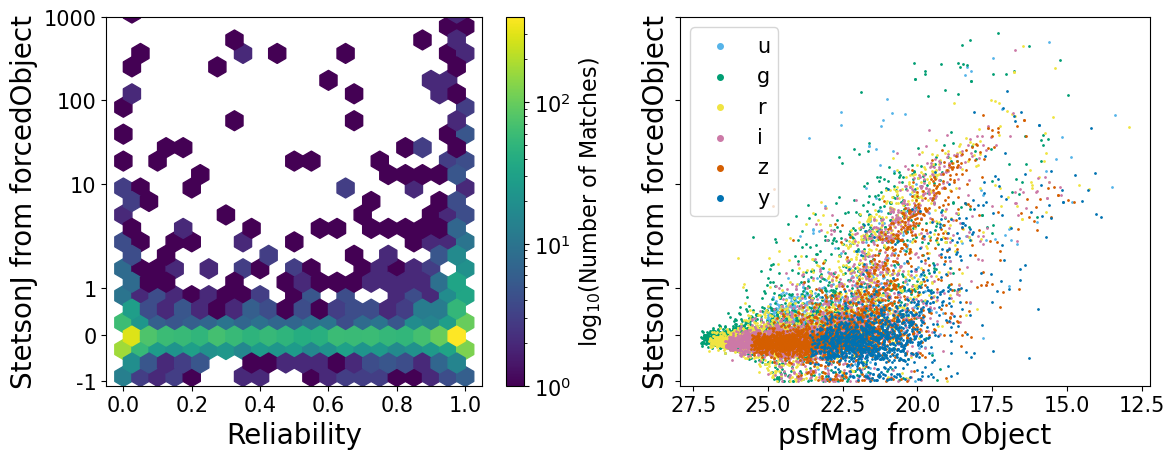

In [39]:
fig, axs = plt.subplots(1,2,figsize=(12,5), sharey=True)
other_fig_00(axs[1])


hb = axs[0].hexbin(
    obj['reliability'],
    obj['r_psfFluxForcedStetsonJ'],
    gridsize=(20, 700),
    bins='log',
    yscale='symlog',
    mincnt=1
)
axs[0].set_xlabel('Reliability')
axs[0].set_ylabel('StetsonJ from forcedObject')
cbar = plt.colorbar(hb, ax=axs[0])
cbar.set_label(label=r'log$_{10}$(Number of Matches)', fontsize=16)

# make legend by plotting dummy pts

plt.tight_layout()
fig.savefig('../../plots/stetsonJ.pdf')


# Show one lightcurve (Figure 7)

In [40]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude"""
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux + sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux - sciFluxErr)
    magErr = -(upper_mag - lower_mag) / 2
    return mag, magErr

def plot_mag_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    """Plot light curves in magnitude scale"""
    mag_values = []  # Store magnitudes for setting axis limits
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        # Compute magnitudes and errors
        mag, magErr = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])
        ax.errorbar(
            band_lc[x_name],
            mag,
            magErr,
            fmt="o",
            label=band,
            color=color,
            alpha=1,
            markersize=5,
            capsize=3,
            elinewidth=1,
        )
        mag_values.extend(mag.dropna().values)  # Collect magnitude values
    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude (AB)")
    ax.invert_yaxis()  # Magnitudes are plotted with brighter objects lower
    if show_legend:
        ax.legend(fontsize=12)  # Show legend in top-left panel only
    return mag_values  # Return magnitudes for axis scaling

450.85868276944035


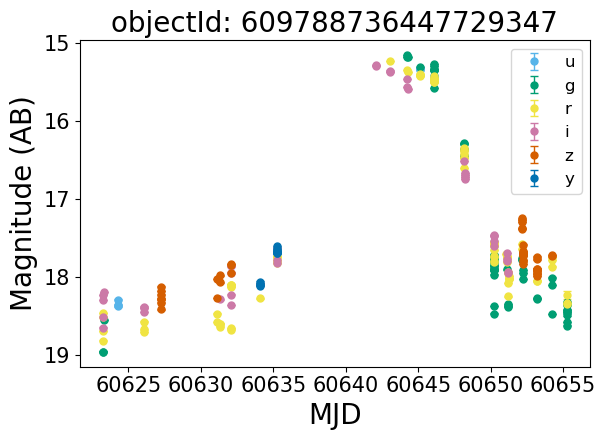

In [41]:
for i, row in reliable[reliable['r_psfFluxForcedStetsonJ'] > 150].iterrows():
    fig, ax = plt.subplots()
    _ = plot_mag_scale(ax, row.objectForcedSource, 'psfFlux', 'psfFluxErr', 'midpointMjdTai', 'MJD', True)
    ax.set_title(f'objectId: {row.objectId}')
    print(row['r_psfFluxForcedStetsonJ'])
plt.tight_layout()
plt.savefig('../../plots/cv_lightcurve.pdf')

In [42]:
obj[obj['objectId'] == 611255759837090542].iloc[0]['objectForcedSource']

,parentObjectId,coord_ra,coord_dec,visit,detector,band,psfFlux,psfFluxErr,psfFlux_flag,psfDiffFlux,psfDiffFluxErr,psfDiffFlux_flag,diff_PixelFlags_nodataCenter,pixelFlags_bad,pixelFlags_cr,pixelFlags_crCenter,pixelFlags_edge,pixelFlags_interpolated,pixelFlags_interpolatedCenter,pixelFlags_nodata,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,invalidPsfFlag,tract,patch,forcedSourceId,psfMag,psfMagErr,midpointMjdTai
0,0,53.139458,-27.720301,2024110800245,2,i,169290.421875,435.299744,False,-307.462677,442.991241,False,False,False,False,False,False,False,False,False,False,False,False,False,False,5063,34,600320187510569386,18.328419,0.002792,60623.258521
1,0,53.139458,-27.720301,2024110800246,2,r,120050.820312,323.520233,False,-281.404907,326.534576,False,False,False,False,False,False,False,False,False,False,False,False,False,False,5063,34,600320187644787269,18.701588,0.002926,60623.259329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0,53.139458,-27.720301,2024121000433,2,g,80239.187500,1358.748047,False,-150.615051,1357.999023,False,False,False,False,False,False,False,False,False,False,False,False,False,False,5063,34,600460950231865111,19.139034,0.018387,60655.249581
279,0,53.139458,-27.720301,2024121000434,2,g,82257.187500,690.338196,False,-279.871033,688.658203,False,False,False,False,False,False,False,False,False,False,False,False,False,False,5063,34,600460950366082431,19.112066,0.009112,60655.249976


In [43]:
mQ = pd.read_csv('../../data/final_data_products/obj_x_milliquas.csv')
sim = pd.read_csv('../../data/final_data_products/obj_x_simbad.csv')

In [44]:
mQ[mQ['objectId'] == 611255759837090542]

,objectId,field_X,name_X,cat_X,F_X,ra_MIL,dec_MIL,RA_MIL,DEC_MIL,NAME_MIL,TYPE_MIL,RMAG_MIL,BMAG_MIL,COMMENT_MIL,R_MIL,B_MIL,Z_MIL,CITE_MIL,ZCITE_MIL,XNAME_MIL,RNAME_MIL,LOBE1_MIL,LOBE2_MIL,_dist_arcsec,otype_consolidated,F_opt,g_psfMag,i_psfMag,r_psfMag,u_psfMag,y_psfMag,z_psfMag,g_psfFlux,g_psfFluxErr,i_psfFlux,i_psfFluxErr,r_psfFlux,r_psfFluxErr,u_psfFlux,u_psfFluxErr,y_psfFlux,y_psfFluxErr,z_psfFlux,z_psfFluxErr,refExtendedness,near_bright_flag
350,611255759837090542,ECDFS,2CXO J033233.4-274313,CSC2.1,1.720000e-16,53.139458,-27.720301,53.139435,-27.720284,3D-HST 38237,AX,17.25,19.35,p,1,-,0.103,GSAC,GSAC,CXOG J033233.4-274311,,,,0.000597,AGN,5.580605e-13,19.469292,18.226532,18.581692,21.008783,17.698914,17.910763,59194.76,25.193842,185946.22,52.392517,134067.5,35.30859,14337.948,103.67714,302297.38,529.8427,248710.97,82.172714,1.0,False


450.85868276944035
23.846379933609285


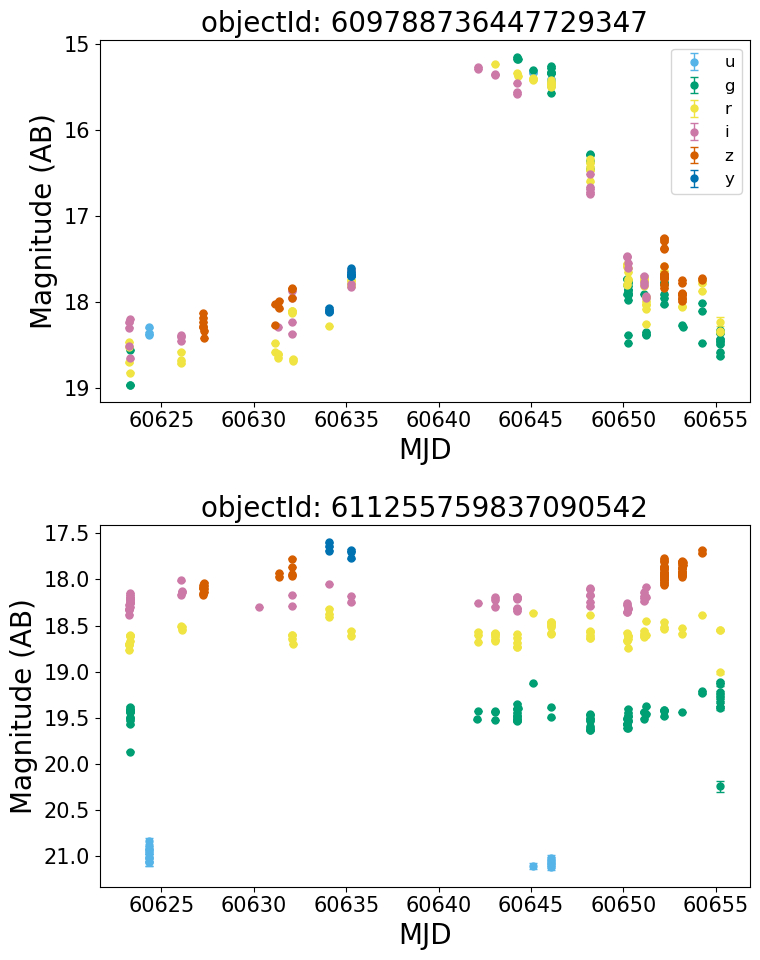

In [45]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
for i, objectId in enumerate([609788736447729347, 611255759837090542]):
    row = obj[obj['objectId'] == objectId].iloc[0]
    if i == 0:
        _ = plot_mag_scale(axs[i], row.objectForcedSource, 'psfFlux', 'psfFluxErr', 'midpointMjdTai', 'MJD', True)
    if i > 0:
        _ = plot_mag_scale(axs[i], row.objectForcedSource, 'psfFlux', 'psfFluxErr', 'midpointMjdTai', 'MJD', False)
    axs[i].set_title(f'objectId: {row.objectId}')
    print(row['r_psfFluxForcedStetsonJ'])
    plt.tight_layout()
plt.savefig('../../plots/cv_agn_lightcurve.pdf')


# x-ray optical plots (Figure 8)

In [46]:
mQ = pd.read_csv('../../data/final_data_products/obj_x_milliquas.csv')

# combine Narrow line AGN and QSO into QSO label
key = {'B':'BL Lac', 'Q': 'QSO', 'A':'AGN', 'N': 'AGN', 'K': 'QSO', 'X': 'X-ray Obj'}
mQ['otype_consolidated'] = [key[x] for x in mQ['TYPE_MIL'].str[0]]

# get stars and cv
sim = pd.read_csv('../../data/final_data_products/obj_x_simbad.csv')
gaia_dp1_ecdfs = pd.read_csv('../../data/intermediate_data_products/gaia_dp1_ecdfs.csv')
gaia_dp1_ecdfs = gaia_dp1_ecdfs[gaia_dp1_ecdfs['OType'] == 'Star']

In [47]:
def add_obj_cols_on_id(df, obj, cols, left_on='objectId'):
    cols = cols + ['objectId']
    return df.merge(obj[cols], how='left', left_on=left_on, right_on='objectId')
    
sim = add_obj_cols_on_id(sim, obj, cols=['F_opt', 'g_psfMag', 'i_psfMag', 'r_psfMag', 'u_psfMag', 'y_psfMag', 'z_psfMag', 'refExtendedness', 'near_bright_flag'])
# mQ = add_obj_cols_on_id(mQ, obj, cols=['F_opt', 'g_psfMag', 'i_psfMag', 'r_psfMag', 'u_psfMag', 'y_psfMag', 'z_psfMag', 
#                                        'g_psfFlux', 'g_psfFluxErr', 'i_psfFlux', 'i_psfFluxErr', 'r_psfFlux', 'r_psfFluxErr', 
#                                        'u_psfFlux', 'u_psfFluxErr', 'y_psfFlux', 'y_psfFluxErr', 'z_psfFlux', 'z_psfFluxErr',
#                                        'refExtendedness', 'near_bright_flag'])

In [48]:
def get_mag_from_flux(flux, band='r'):
    filters = {
            'u': (367, 40),
            'g': (482, 137),
            'r': (622, 132),
            'i': (754, 127),
            'z': (869, 118),
            'y': (971, 65),
        }
    
    from astropy.constants import c
    lambda_eff_nm, delta_lambda_nm = filters[band]
    lambda_eff = lambda_eff_nm * u.nm
    delta_lambda = delta_lambda_nm * u.nm

    # Convert wavelength to frequency bandwidth using Δν = c * Δλ / λ^2
    delta_nu = (c * delta_lambda / lambda_eff**2).to(u.Hz)
    
    # flux density in this band: f_nu = F / Δν
    f_nu = flux * u.erg / u.s / u.cm**2  / delta_nu

    # convert to nJy
    f_nJy = f_nu.to(u.nJy)

    # convert to magnitude
    mag = u.nJy.to(u.ABmag, f_nJy.value)

    return mag

### define GAIA lsst color transformation from 
https://urldefense.com/v3/__https://community.lsst.org/t/mapping-gaia-magnitudes-to-lsst-bands/8927__;!!K-Hz7m0Vt54!kCPpffrFPi3S2lFNANF-SY2Gux3E3u6X-MZq4OmT5x6UUc7egjnQL11bl0FoICXobamZ9ILi3T7YQy7tti959W82TA$

In [49]:
g_minus_i_LSST = lambda x: (-0.079 + 1.184*x + 0.2218*x**2 - 0.1013*x**3)

### calculate quiescent and outburst fluxes fro CV


In [50]:
print(sim[sim['otype_SIM'] == 'CV*'].main_id_SIM.values, sim[sim['otype_SIM'] == 'CV*'].objectId.values)
cv = sim[sim['otype_SIM'] == 'CV*'].iloc[0]

phot = obj[obj['objectId'] == 609788736447729347].iloc[0].objectForcedSource
# fig, ax = plt.subplots()
# _ = plot_mag_scale(ax, phot, 'psfFlux', 'psfFluxErr', 'midpointMjdTai', 'MJD', True)

['CRTS J033349.8-282244'] [609788736447729347]


In [51]:
bands = 'gri'
mask_q = (phot['midpointMjdTai'] < 60632) | (phot['midpointMjdTai'] > 60651)
mask_o = (phot['midpointMjdTai'] > 60640) & (phot['midpointMjdTai'] < 60645)
# fig, ax = plt.subplots()
# _ = plot_mag_scale(ax, phot[mask_q], 'psfFlux', 'psfFluxErr', 'midpointMjdTai', 'MJD', True)
# fig, ax = plt.subplots()
# _ = plot_mag_scale(ax, phot[mask_o], 'psfFlux', 'psfFluxErr', 'midpointMjdTai', 'MJD', True)
# plt.show()

quiescent_flux = {}
outburst_flux = {}
for band in bands:
    quiescent_flux[f'{band}_psfFlux'] = phot[mask_q].query(f'band=="{band}"')['psfFlux'].mean()    
    quiescent_flux[f'{band}_psfMag'] = phot[mask_q].query(f'band=="{band}"')['psfMag'].mean()    
    outburst_flux[f'{band}_psfFlux'] = phot[mask_o].query(f'band=="{band}"')['psfFlux'].mean()    
    outburst_flux[f'{band}_psfMag'] = phot[mask_o].query(f'band=="{band}"')['psfMag'].mean()    
    outburst_flux[f'{band}_psfMag'] = phot[mask_o].query(f'band=="{band}"')['psfMag'].mean()    
    outburst_flux[f'{band}_psfMag'] = phot[mask_o].query(f'band=="{band}"')['psfMag'].mean()    

### make full plot

In [52]:
obj['r_psfFluxForcedStetsonJ']

0        6.857022
1       48.752268
          ...    
4511         <NA>
4512         <NA>
Name: r_psfFluxForcedStetsonJ, Length: 4513, dtype: double[pyarrow]

In [53]:
# stars_and_cvs = sim[sim['otype_SIM'].isin(['*', 'CV*'])].dropna(subset=['F_opt'])

def make_plot_00(ax, J=3):
    band = 'i'

    sub = add_obj_cols_on_id(mQ, obj_closest, ['reliability', 'r_psfFluxForcedStetsonJ'])
    sub = sub[sub['reliability'] > .9]
    
    for i, cat in enumerate(['4XMMDR14', 'CSC2.1', 'eRASS1', 'XMMSL3', '2SXPS',]):
        # plot dummy plots for legend
        ax.scatter([0], [0], marker='.', s=100, label=cat, color=CAT_COLORS[cat], rasterized=True)
    
        mask1 = np.array(sub['cat_X']) == cat
        mask2 = (sub[f'{band}_psfFlux'] / sub[f'{band}_psfFluxErr']) > 5
        mask = mask1 & mask2

        J_mask = sub['r_psfFluxForcedStetsonJ'] > J

        ax.scatter(np.log10(sub['F_X'][mask][~J_mask]), sub[f'{band}_psfMag'][mask][~J_mask], marker='.', color=CAT_COLORS[cat], rasterized=True)
        ax.scatter(np.log10(sub['F_X'][mask][J_mask]), sub[f'{band}_psfMag'][mask][J_mask], marker='o', facecolors='none', edgecolors=CAT_COLORS[cat], rasterized=True)
    
    # plot dummy plots for legend
    ax.scatter([0], [0], marker='o', s=100, label=fr'Stetson J > {J}', facecolors='none', edgecolors='grey', rasterized=True)
        
    # plot bounds
    Fx = np.logspace(-17, -12, 6)
    bounds = [-2, -1 , 0, 1, 2]
    ls = ['dotted', 'dashed', 'solid', 'dashed', 'dotted']
    for i, bound in enumerate(bounds):
        ax.plot(np.log10(Fx), get_mag_from_flux(Fx * 10 ** bound, band=band), color='k', linestyle=ls[i], alpha=.3)
    
    ax.set_xlim([-17, -12])
    ax.set_ylim([15, 29])
    
    # Labels and title
    ax.set_xlabel('$log(F_x)~[erg/s/cm^2]$')
    ax.set_ylabel(f'${band}$ Magnitude')
    
    ax.set_title(f"X-ray Flux vs {band} Magnitude (Milliquas)")
    
    # Legend
    ax.legend(prop={'size': 12}, loc=1)


def make_plot_01(ax, J=3):
    band = 'i'


    for i, cat in enumerate(['4XMMDR14', 'CSC2.1', 'eRASS1', 'XMMSL3', '2SXPS',]):
        # plot dummy plots for legend
        ax.scatter([0], [0], marker='.', s=100, label=cat, color=CAT_COLORS[cat], rasterized=True)
        
        mask1 = np.array(reliable['cat_X']) == cat
        mask2 = (reliable[f'{band}_psfFlux'] / reliable[f'{band}_psfFluxErr']) > 5
        mask = mask1 & mask2

        J_mask = reliable['r_psfFluxForcedStetsonJ'] > J

        ax.scatter(np.log10(reliable['F_X'][mask][~J_mask]), reliable[f'{band}_psfMag'][mask][~J_mask], marker='.', color=CAT_COLORS[cat], rasterized=True)
        ax.scatter(np.log10(reliable['F_X'][mask][J_mask]), reliable[f'{band}_psfMag'][mask][J_mask], marker='o', facecolors='none', edgecolors=CAT_COLORS[cat], rasterized=True)
    
    # plot dummy plots for legend
    ax.scatter([0], [0], marker='o', s=100, label=fr'Stetson J > {J}', facecolors='none', edgecolors='grey', rasterized=True)
     
    # plot bounds
    Fx = np.logspace(-17, -12, 6)
    bounds = [-2, -1 , 0, 1, 2]
    ls = ['dotted', 'dashed', 'solid', 'dashed', 'dotted']
    for i, bound in enumerate(bounds):
        ax.plot(np.log10(Fx), get_mag_from_flux(Fx * 10 ** bound, band=band), color='k', linestyle=ls[i], alpha=.3)
    
    ax.set_xlim([-17, -12])
    ax.set_ylim([15, 29])
    
    # Labels and title
    ax.set_xlabel('$log(F_x)~[erg/s/cm^2]$')
    ax.set_ylabel(f'${band}$ Magnitude')
    
    ax.set_title(f"X-ray Flux vs {band} Magnitude (Reliable Matches)")
    
    # Legend
    ax.legend(prop={'size': 12}, loc=1)

def make_plot_10(ax):
    # Plot points with colors based on field
    for otype in mQ['otype_consolidated'].unique():
        if otype == 'X-ray Obj':
            continue
        mask = np.array(mQ['otype_consolidated']) == otype
        ax.scatter((mQ['g_psfMag'][mask] + mQ['r_psfMag'][mask]) - (mQ['i_psfMag'][mask] + mQ['z_psfMag'][mask]), 
                   np.log10(mQ['F_X'][mask])-np.log10(mQ['F_opt'][mask]), marker='.', label=otype, s=30, rasterized=True)

    sub = sim[sim['otype_SIM'].isin(['*', '**'])].dropna(subset=['F_opt'])
    sub = add_obj_cols_on_id(sub, obj_closest, ['reliability'])
    sub = sub[sub['reliability'] > .9]

    mask = np.array(~sub['near_bright_flag'])
    ax.scatter((sub['g_psfMag'][mask] - sub['i_psfMag'][mask]), 
               np.log10(sub['F_X'][mask])-np.log10(sub['F_opt'][mask]), marker='*', color='purple', label='Star', s=100, rasterized=True)

    qfactor = 10**(-0.4 *( quiescent_flux['g_psfMag'] - cv['g_psfMag']))
    ax.scatter((quiescent_flux['g_psfMag'] - quiescent_flux['i_psfMag']), 
               np.log10(cv['F_X'])-np.log10(cv['F_opt']*qfactor), marker='*', color='cyan', label='CV \n(quiescent)', s=100, edgecolors= "cyan")
    
    # ofactor = 10**(-0.4 *( outburst_flux['g_psfMag'] - cv['g_psfMag']))
    # ofactor_xray = 100
    
    # ax.scatter((outburst_flux['g_psfMag'] - outburst_flux['i_psfMag']), 
    #            np.log10(cv['F_X']*ofactor_xray)-np.log10(cv['F_opt']*ofactor), marker='*', color='cyan', label='CV \n(outburst)', s=200)
    # ax.plot([(quiescent_flux['g_psfMag'] - quiescent_flux['i_psfMag']), (outburst_flux['g_psfMag'] - outburst_flux['i_psfMag'])],
    #          [np.log10(cv['F_X'])-np.log10(cv['F_opt']*qfactor), np.log10(cv['F_X']*ofactor_xray)-np.log10(cv['F_opt']*ofactor)],
    #          linestyle=':', color='silver')

    ax.scatter((gaia_dp1_ecdfs['g_psfMag'] - gaia_dp1_ecdfs['i_psfMag']), 
                   np.log10(gaia_dp1_ecdfs['FFB'])-np.log10(gaia_dp1_ecdfs['F_opt']), marker='*', color='purple', s=100, rasterized=True)  

    
    # Labels and title
    # ax.set_xlabel('$(g+r) - (i+z)$')
    ax.set_xlabel('$g - i$')
    ax.set_ylabel('$log(F_X/F_{opt})$')
    
    ax.set_xlim([-2, 6])
    ax.set_ylim([-5, 2.5])

    ax.set_title("Color vs X-ray-to-Optical Flux Ratio \n(Milliquas + Select SIMBAD)")

    x = np.linspace(-1, 2, 100)
    y = g_minus_i_LSST(x)-3.5
    ax.plot(x, y, color='k', label='Rodriguez+24')
    
    # Legend
    ax.legend(prop={'size': 12})

def make_plot_11(ax):
    mappable = ax.scatter((reliable['g_psfMag'] - reliable['i_psfMag']), 
               np.log10(reliable['F_X'])-np.log10(reliable['F_opt']), 
               marker='.',  s=30, c=reliable['refExtendedness'], cmap='coolwarm')    

    # ax.set_colorbar(label='Extendedness')  
    fig.colorbar(mappable, label='Extendedness', ax=ax)
    
    ax.set_xlabel('$(g+r) - (i+z)$')
    ax.set_ylabel('$log(F_X/F_{opt})$')
    
    ax.set_xlim([-2, 6])
    ax.set_ylim([-5, 2.5])

    x = np.linspace(-1, 2, 100)
    y = g_minus_i_LSST(x)-3.5
    ax.plot(x, y, color='k', label='Rodriguez+24')
    # plt.ylim([-5, 2.5])
    # plt.xlim([-2, 6])
    
    ax.set_title("Color vs X-ray-to-Optical Flux Ratio \n(Reliable Matches)")
    # Legend
    ax.legend(prop={'size': 12})

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: divide by zero encountered in log10
  return getattr(ufunc, method)(*new_inputs, **kwargs)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:492: Runt

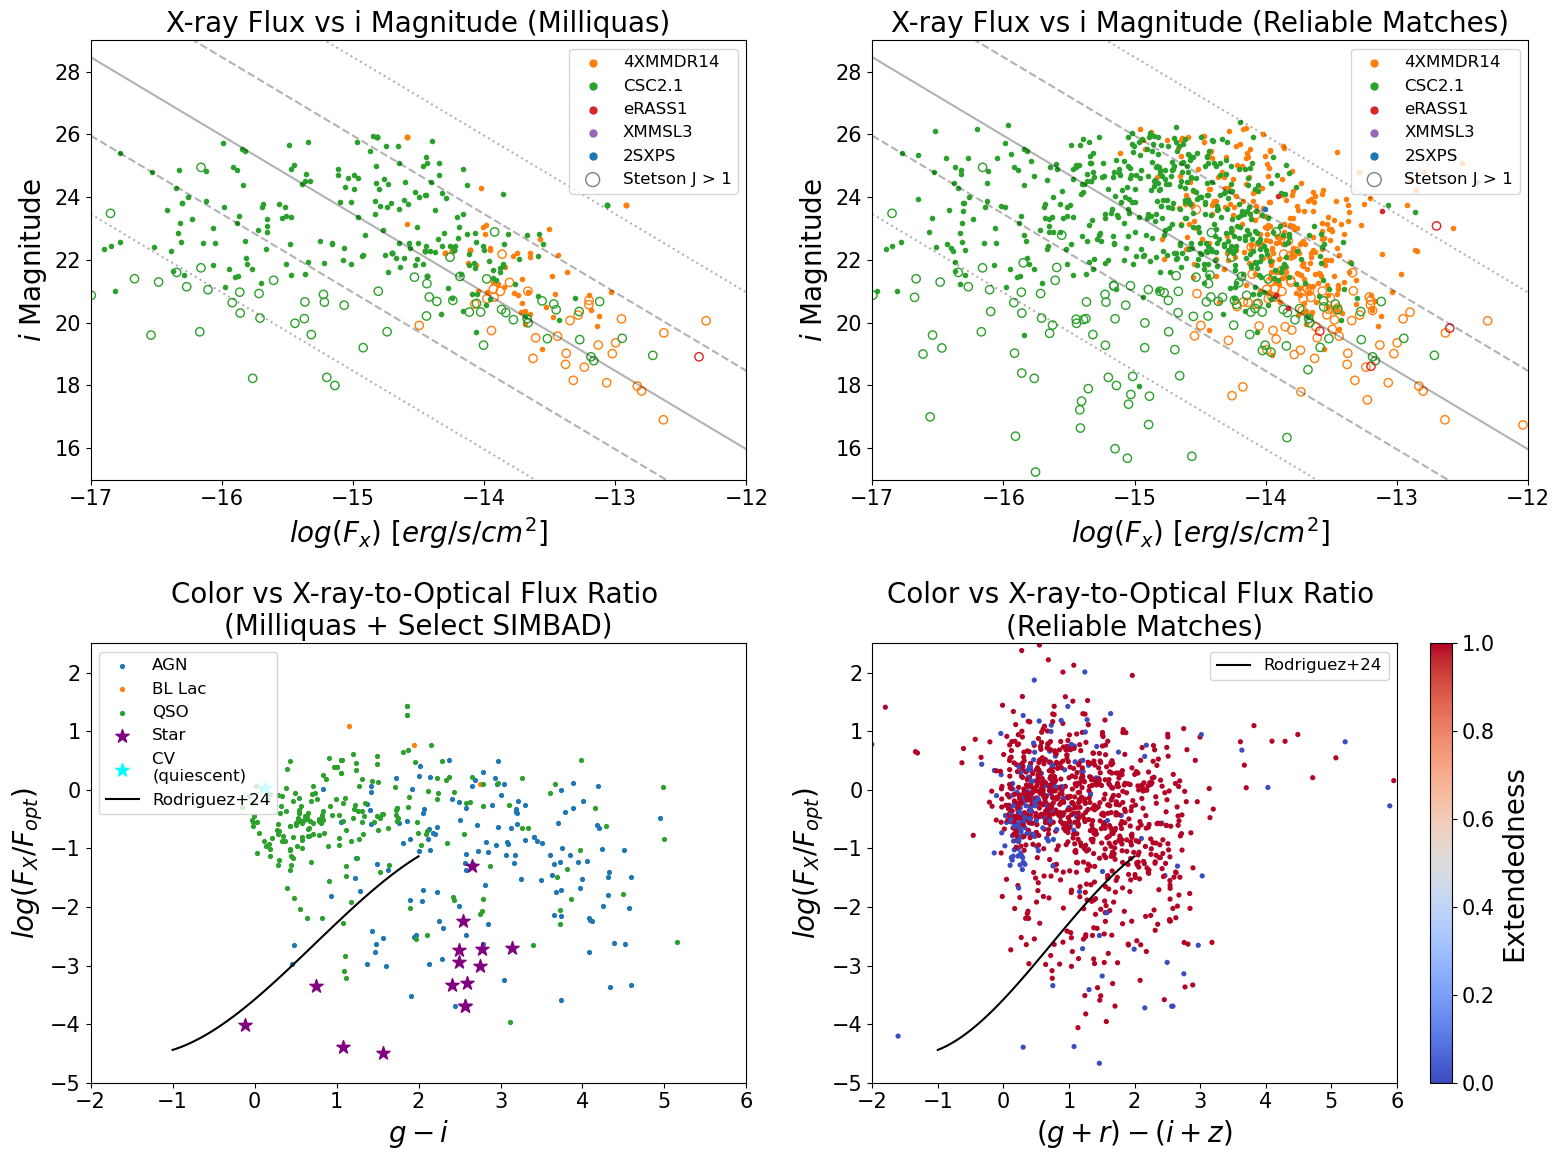

In [54]:
plt.rcParams.update({
    'font.size': 20,          # Double the default (usually ~10)
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15
})

fig, axs = plt.subplots(2,2, figsize=(16, 12))
make_plot_00(axs[0,0], J=1)
make_plot_01(axs[0,1], J=1)
make_plot_10(axs[1,0])
make_plot_11(axs[1,1])
plt.tight_layout()

plt.savefig('../../plots/interesting_plots.pdf')
